## 稠密连接网络DenseNet

### 与ResNet的不同之处
- DenseNet输出是连接；ResNet输出是相加(f(x)=x+g(x))

### 稠密块
- 定义如何连接输入和输出

### 过渡层
- 控制通道数（控制复杂度）

## 稠密块体

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#改良版“批量规范化层，激活层和卷积层”架构
def conv_block(input_channels, num_channels):
    return nn.Sequential(
            nn.BatchNorm2d(input_channels), nn.ReLU(),
            nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [4]:
#一个稠密块有多个卷积块组成，每个卷积块使用相同数量的输出通道。（前向传播中，每个卷积块的输入和输出在通道维度上连接）
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
        
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            #连接通道维度上每个卷积块的输出和输入
            X = torch.cat((X,Y),dim=1)
        return X

In [5]:
#e.g.
blk = DenseBlock(2,3,10) #定义一个有2个输出通道数为10的DenseBlock
X = torch.randn(4,3,8,8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

- 23 = 3 +  2*10

## 过渡层

In [6]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [7]:
#e.g.
blk = transition_block(23,10) #通道数为10的过渡层
blk(Y).shape

torch.Size([4, 10, 4, 4])

- 输出通道数-10，高宽减半

## DenseNet模型

In [8]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [9]:
#4个稠密快
num_channels, growth_rate = 64,32 #num_channels = 64 上层网络的输出通道数；设置稠密快的卷积层通道数为32（growth_rate）
num_convs_in_dense_blocks = [4,4,4,4] #每个（共四个）稠密块使用多少个卷积层
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    #上一个稠密块的输出通道数
    num_channels = num_channels + num_convs*growth_rate
    #每个稠密层之间添加一个过渡层，使用通道数减半
    if i != len(num_convs_in_dense_blocks) - 1: #第一个稠密层之前不用加过渡层
        blks.append(transition_block(num_channels, num_channels // 2)) #高宽减半
        num_channels = num_channels // 2 #通道数减半

In [10]:
#连接全局汇聚层和全连接层输出结果
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval() #设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    #正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X),y), y.numel())
    return metric[0] / metric[1]

In [11]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                           legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        #训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches,
                            (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f},'
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.139, train acc 0.950, test acc 0.887
2666.7 examples/sec on cuda:0


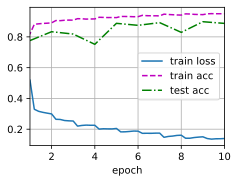

In [12]:
#训练模型
lr ,num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96) #resize 一下图片大小
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())